<h1>Forecasting</h1><h2 align="center">ARIMA</h2>

In [1]:
from pandas import read_csv, DataFrame, Series
from statsmodels.tsa.arima.model import ARIMA
from dslabs_functions import series_train_test_split, HEIGHT

file_tag = "timeseries_traffic"
target = "Total"
filename = "../../../data/forecast_traffic_single.csv"
timecol = "Timestamp"
measure: str = "R2"

data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
data = data.sort_values(['Timestamp'], ascending=True)

series: Series = data[target]
train, test = series_train_test_split(data, trn_pct=0.90)

predictor = ARIMA(train, order=(3, 1, 2))
model = predictor.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                 2678
Model:                 ARIMA(3, 1, 2)   Log Likelihood              -13076.299
Date:                Wed, 27 Dec 2023   AIC                          26164.598
Time:                        13:09:04   BIC                          26199.952
Sample:                    10-01-2023   HQIC                         26177.388
                         - 10-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9896      0.147      6.745      0.000       0.702       1.277
ar.L2         -0.2782      0.058     -4.828      0.000      -0.391      -0.165
ar.L3         -0.1099      0.039     -2.841      0.0

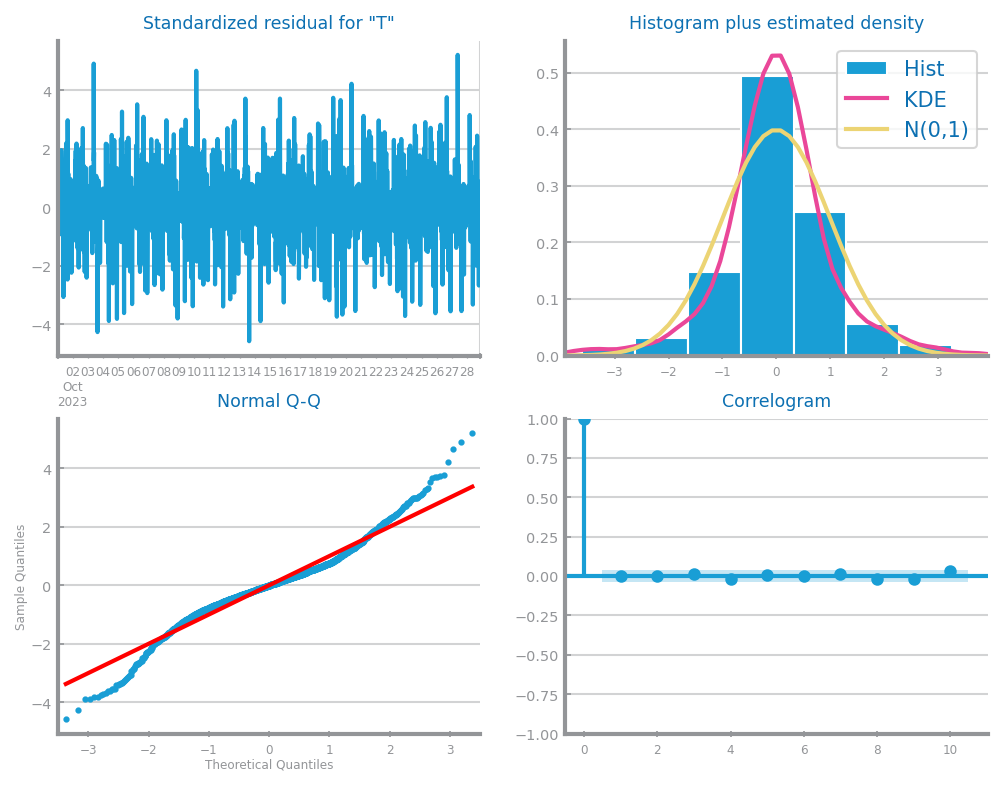

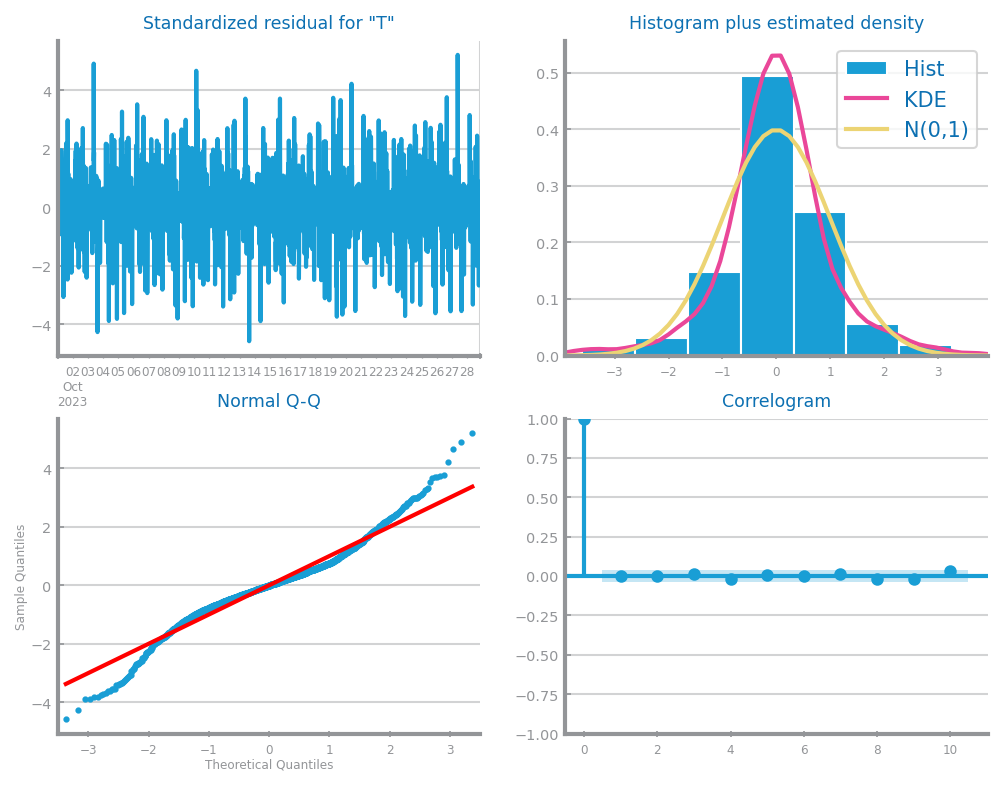

In [2]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))

In [3]:
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart


def arima_study(train: Series, test: Series, measure: str = "R2"):
    d_values = (0, 1, 2)
    p_params = (1, 2, 3, 5, 7, 10)
    q_params = (1, 3, 5, 7)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * HEIGHT, HEIGHT))
    for i in range(len(d_values)):
        d: int = d_values[i]
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                arima = ARIMA(train, order=(p, d, q))
                model = arima.fit()
                prd_tst = model.forecast(steps=len(test), signal_only=False)
                eval: float = FORECAST_MEASURES[measure](test, prd_tst)
                print(f"ARIMA ({p}, {d}, {q})", eval)
                if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                    best_performance: float = eval
                    best_params["params"] = (p, d, q)
                    best_model = model
                yvalues.append(eval)
            values[q] = yvalues
        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params

ARIMA (1, 0, 1) -0.030889453764387342
ARIMA (2, 0, 1) -0.030695142934336728
ARIMA (3, 0, 1) -0.03067085548516424
ARIMA (5, 0, 1) -0.03132326476800684
ARIMA (7, 0, 1) 0.04932201990362517
ARIMA (10, 0, 1) 0.04985975932448217
ARIMA (1, 0, 3) -0.03050372338107099
ARIMA (2, 0, 3) 0.04995127622083917
ARIMA (3, 0, 3) -0.030707479848168795
ARIMA (5, 0, 3) 0.07430682390520349
ARIMA (7, 0, 3) -0.030502350253233557
ARIMA (10, 0, 3) 0.048105615395865664
ARIMA (1, 0, 5) -0.029825632103333444
ARIMA (2, 0, 5) 0.05268035711685226
ARIMA (3, 0, 5) 0.0497106065747267
ARIMA (5, 0, 5) -0.03333822773672557
ARIMA (7, 0, 5) -0.026427016297627448
ARIMA (10, 0, 5) 0.048726470531158084
ARIMA (1, 0, 7) -0.027433314778803286
ARIMA (2, 0, 7) 0.06078003419240863
ARIMA (3, 0, 7) 0.04919302344415799
ARIMA (5, 0, 7) 0.046397939357985085
ARIMA (7, 0, 7) -0.3985247039782178
ARIMA (10, 0, 7) 0.047553561346884154
ARIMA (1, 1, 1) -0.19508029595460186
ARIMA (2, 1, 1) -0.19467960053548006
ARIMA (3, 1, 1) -0.19395343625071493


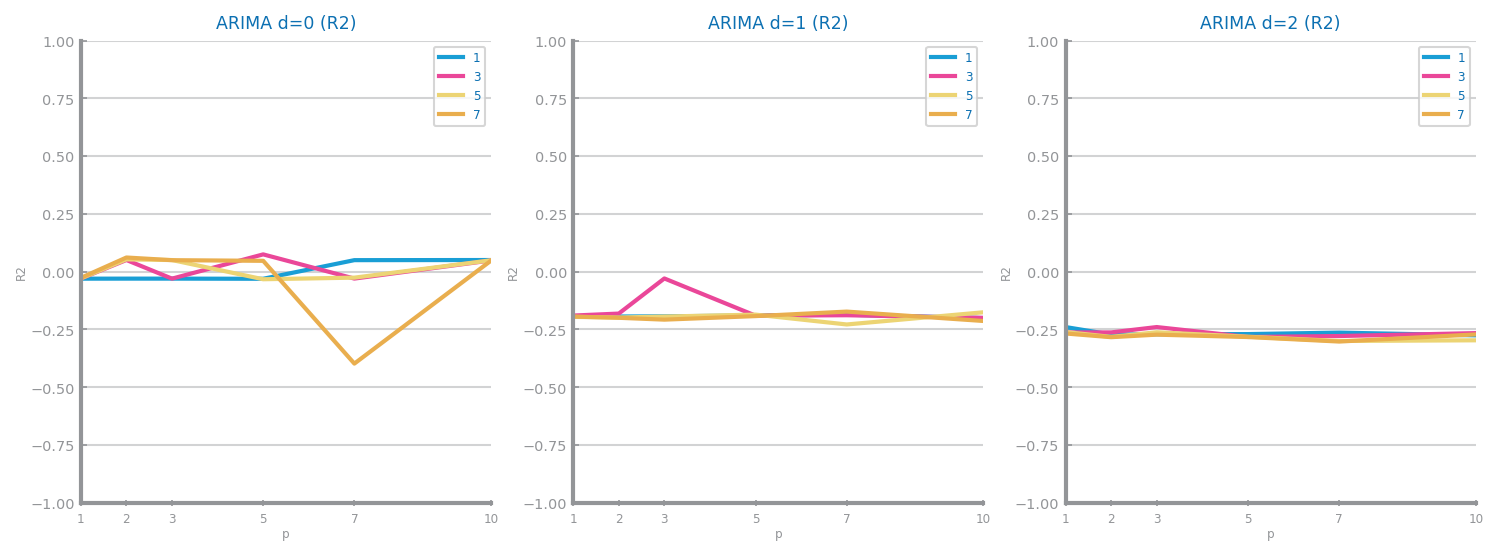

In [4]:
from matplotlib.pyplot import savefig

best_model, best_params = arima_study(train, test, measure=measure)
savefig(f"images/{file_tag}_arima_{measure}_study.png")

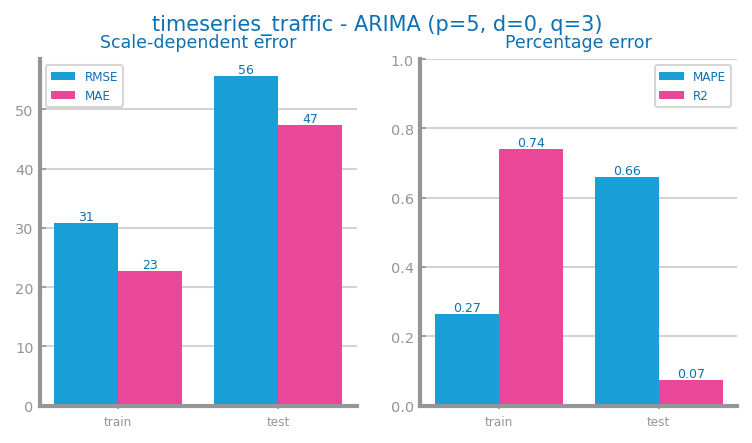

In [5]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

plot_forecasting_eval(
    train, test, prd_trn, prd_tst, title=f"{file_tag} - ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"images/{file_tag}_arima_{measure}_eval.png")

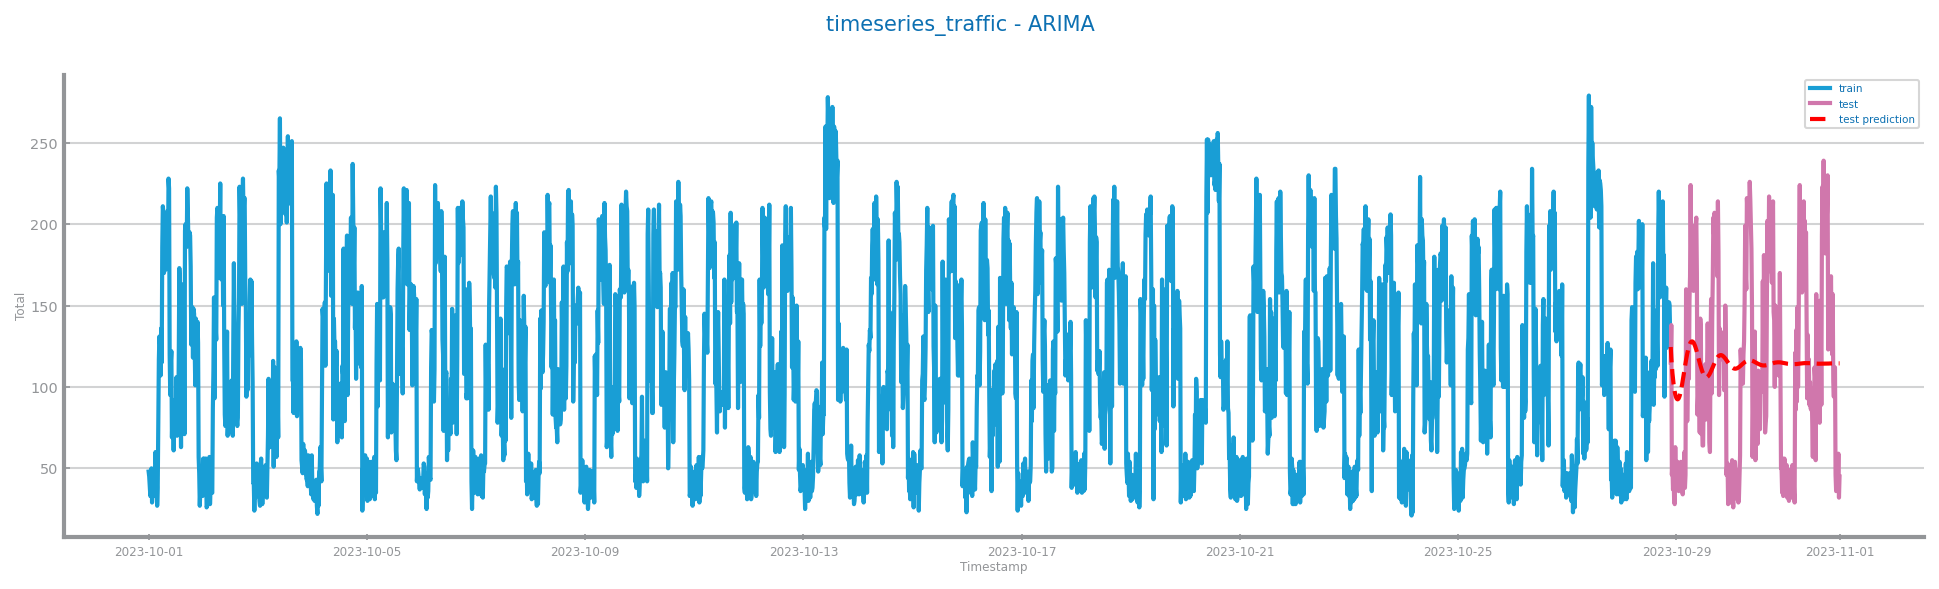

In [6]:
from dslabs_functions import plot_forecasting_series

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - ARIMA ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_arima_{measure}_forecast.png")